# Lab 2: Cats vs Dogs

**Deadline**: Oct 8, 11:59pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Tinglin (Francis) Duan

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1TMRj0IwWv7w-pMCGXIjLQkEreErQYw6a/view?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)//(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

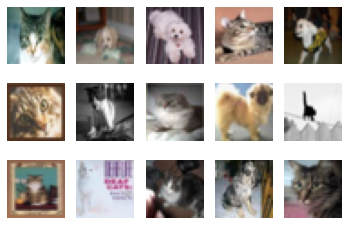

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in val_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
print(len(train_loader))
print(len(test_loader))
print(len(val_loader))

# There are 8000 training examples and 2000 each of the testing and validation examples.

8000
2000
2000


### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

It is important to have a validation set as you want to verify that the model is trained well. There is always the risk of overfitting / underfitting the model, as it may seem like the model works if there is small error or loss. We use the validation set to introduce unseen data to run the model such that we can confirm that it works. 

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
mnist_train = train_loader
mnist_val = test_loader

class MNISTClassifier(nn.Module): 
  def __init__(self):
    super(MNISTClassifier, self).__init__()
    self.conv1 = nn.Conv2d(1,5,3,2,1)#in, out, k_size, stride, pad self.pool = nn.MaxPool2d(2, 2) #k_size, stride
    self.conv2 = nn.Conv2d(5,10,5,1,1)
    self.fc1 = nn.Linear(250, 16) #in, out
    self.fc2 = nn.Linear(16, 10)

def forward(self, x):
  x = F.ReLU(self.conv1(x)) 
  x = self.pool(x)
  x = F.ReLU(self.conv2(x))
  x = x.view(-1, 150)
  x = F.sigmoid(self.fc1(x)) 
  x = self.fc2(x)
  return x

def train(model, data, batch_size=32, num_epochs=4): 
  
  train_loader1 = torch.utils.data.DataLoader(data, batch_size=batch_size)
  criterion = nn.NLLLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) 

  for imgs, labels in train_loader1:
    for epoch in range(num_epochs):
      out = model(imgs)
      loss = criterion(out, labels) 
      loss.backward() 
      optimizer.step()


model = MNISTClassifier() 
train(model, mnist_train)

TypeError: ignored

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
accum = 1
for param in small_net.parameters():
    for i in range(0, len(param.shape)):
      accum = accum*param.shape[i]

print("There are " + str(accum) + " parameters in the small_net")

accum = 1
for param in large_net.parameters():
    for i in range(0, len(param.shape)):
      accum = accum*param.shape[i]
    
print("There are " + str(accum) + " parameters in the small_net")


There are 165375 parameters in the small_net
There are 192000000000000 parameters in the small_net


### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

In [ ]:
# batch_size = 64 
# learning_rate = 0.01
# num_epochs = 30

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, 64, 0.01, 5)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.418125, Train loss: 0.6704066848754883 |Validation err: 0.3785, Validation loss: 0.6523424778133631
Epoch 2: Train err: 0.364875, Train loss: 0.6426583008766175 |Validation err: 0.3705, Validation loss: 0.6487210430204868
Epoch 3: Train err: 0.353375, Train loss: 0.6322054648399353 |Validation err: 0.359, Validation loss: 0.6275773737579584
Epoch 4: Train err: 0.342375, Train loss: 0.6217929873466491 |Validation err: 0.372, Validation loss: 0.6336106583476067
Epoch 5: Train err: 0.33425, Train loss: 0.6123823966979981 |Validation err: 0.3375, Validation loss: 0.620902094990015
Finished Training
Total time elapsed: 18.50 seconds


The following files written to disk:

model_small_bs64_lr0.01_epoch0. \\
model_small_bs64_lr0.01_epoch1 \\
model_small_bs64_lr0.01_epoch2 \\
model_small_bs64_lr0.01_epoch3 \\
model_small_bs64_lr0.01_epoch4 \\
model_small_bs64_lr0.01_epoch4_train_err \\
model_small_bs64_lr0.01_epoch_train_loss \\
model_small_bs64_lr0.01_epoch_val_loss \\
model_small_bs64_lr0.01_epoch_val_err \\


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_net(small_net, 64, 0.01, 30)
## 111.05 seconds to train
    
train_net(large_net, 64, 0.01, 30)
## 124.64 seconds to train

# The large_net took longer as there are more parameters to train

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.32825, Train loss: 0.6051286149024964 |Validation err: 0.339, Validation loss: 0.6161511670798063
Epoch 2: Train err: 0.31775, Train loss: 0.5988569338321685 |Validation err: 0.34, Validation loss: 0.6160510908812284
Epoch 3: Train err: 0.3205, Train loss: 0.5974532868862152 |Validation err: 0.3385, Validation loss: 0.6126508954912424
Epoch 4: Train err: 0.320125, Train loss: 0.5951218860149383 |Validation err: 0.344, Validation loss: 0.613126752898097
Epoch 5: Train err: 0.31175, Train loss: 0.5874869222640992 |Validation err: 0.324, Validation loss: 0.603849595412612
Epoch 6: Train err: 0.305375, Train loss: 0.5835547342300414 |Validation err: 0.3365, Validation loss: 0.6082292729988694
Epoch 7: Train err: 0.307, Train loss: 0.5832296054363251 |Validation err: 0.329, Validation loss: 0.6048325654119253
Epoch 8: Train err: 0.306125, Train loss: 0.5778174822330475 |Validation err: 0.3165, 

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

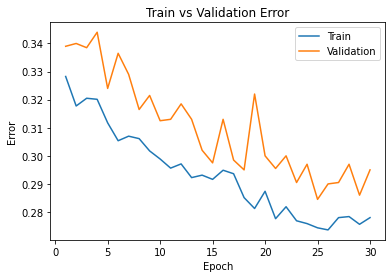

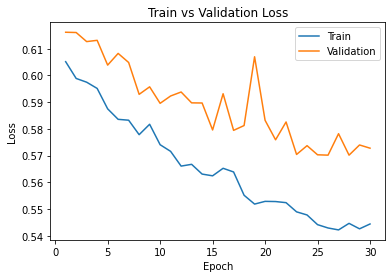

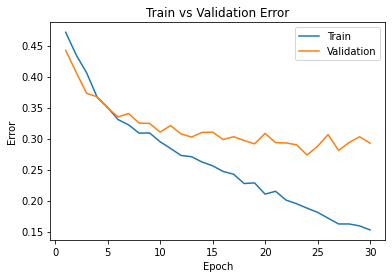

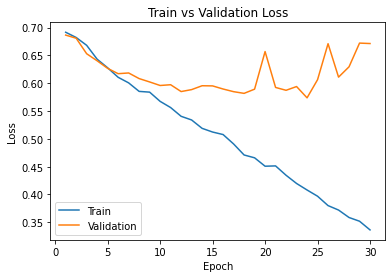

In [ ]:
model_path = get_model_name("small", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

model_path = get_model_name("large", batch_size=64, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

For the small_net, the training curves for both the error and the loss are lower than the validation curves, meaning less error and loss. In both cases, the training curves also trend downward as the epoch increase to smaller values while the validation curves plateau. 

For the large_net, the training curves match up very well with the validation curves while the epoch number is low. As the epochs increase, the two curves tend to diverge, where the training curve continues on a downward linear trend and the validation curve trend in the opposite direction. 

As the training error decreases and the validation error does not, these cases are considered to be overfitting. This can be seen in the areas where Epoch > 15. In the areas where Epoch < 10, the model is underfitting as the training error continues to decrease even though the complexity is increasing with the epochs.




## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360004425049 |Validation err: 0.467, Validation loss: 0.6924686543643475
Epoch 2: Train err: 0.448625, Train loss: 0.6922589735984802 |Validation err: 0.4305, Validation loss: 0.6916493363678455
Epoch 3: Train err: 0.43575, Train loss: 0.6916067390441895 |Validation err: 0.4285, Validation loss: 0.6908544506877661
Epoch 4: Train err: 0.430125, Train loss: 0.6908613820075988 |Validation err: 0.424, Validation loss: 0.6896596867591143
Epoch 5: Train err: 0.434125, Train loss: 0.6899198398590088 |Validation err: 0.4195, Validation loss: 0.688694279640913
Epoch 6: Train err: 0.435875, Train loss: 0.6887419700622559 |Validation err: 0.4195, Validation loss: 0.6867837496101856
Epoch 7: Train err: 0.436625, Train loss: 0.6873781762123108 |Validation err: 0.4185, Validation loss: 0.6851996630430222
Epoch 8: Train err: 0.43725, Train loss: 0.6859267873764038 |Validation err

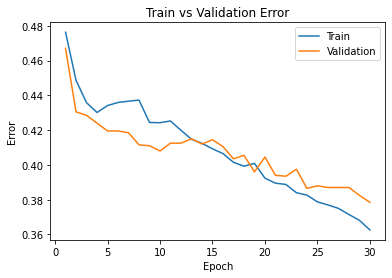

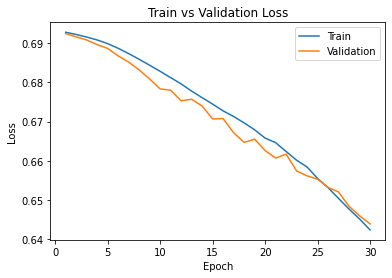

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()

train_net(large_net, 64, 0.001, 30)
model_path = get_model_name("large", batch_size=64, learning_rate=0.001, epoch=29)
plot_training_curve(model_path)


The model takes slightly longer to train than before. We notice with the lower learning rate that the training and validation curves are much more similar. The overall error continues to decrease with the increasing epochs, but even with the lower learning rate of 0.001, the error was still higher. 

Essentially, having a lower learning rate does not increase efficiency, as the run time is greater and the error is actually greater, so this could be considered to be ineffective.


### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4275, Train loss: 0.6742977547645569 |Validation err: 0.3765, Validation loss: 0.6370316985994577
Epoch 2: Train err: 0.369625, Train loss: 0.6419942178726197 |Validation err: 0.375, Validation loss: 0.6421687360852957
Epoch 3: Train err: 0.36025, Train loss: 0.6315926456451416 |Validation err: 0.338, Validation loss: 0.6223371177911758
Epoch 4: Train err: 0.334125, Train loss: 0.6084355125427247 |Validation err: 0.333, Validation loss: 0.6210155226290226
Epoch 5: Train err: 0.327, Train loss: 0.5968132178783416 |Validation err: 0.316, Validation loss: 0.593926228582859
Epoch 6: Train err: 0.3065, Train loss: 0.5736211636066437 |Validation err: 0.308, Validation loss: 0.5758339520543814
Epoch 7: Train err: 0.286625, Train loss: 0.557759182214737 |Validation err: 0.3255, Validation loss: 0.5994757367298007
Epoch 8: Train err: 0.287625, Train loss: 0.5451903882026672 |Validation err: 0.3075,

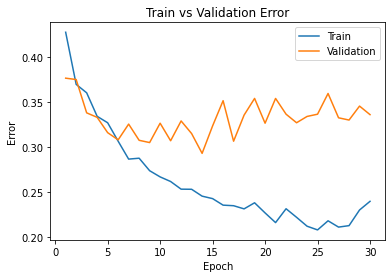

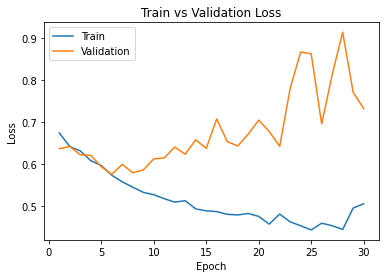

In [ ]:
large_net = LargeNet()
train_net(large_net, 64, 0.1, 30)
model_path = get_model_name("large", batch_size=64, learning_rate=0.1, epoch=29)
plot_training_curve(model_path)

The model takes nearly the same amount of time to run with the higher learning rate. We see a trend of decreasing validation loss and error up until about epoch = 5, when it then begins to reverse its trend to an upward direction diverging from the training error and loss.

We also see that the change in error and loss as the epochs increase is much more significant with this higher learning rate of 0.1, compared to the learning rate of 0.01.

### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379440844059 |Validation err: 0.478, Validation loss: 0.6926823854446411
Epoch 2: Train err: 0.457625, Train loss: 0.6924103945493698 |Validation err: 0.434, Validation loss: 0.6917425096035004
Epoch 3: Train err: 0.437, Train loss: 0.6916500553488731 |Validation err: 0.4265, Validation loss: 0.6909130215644836
Epoch 4: Train err: 0.433625, Train loss: 0.6908449865877628 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935664117336 |Validation err: 0.424, Validation loss: 0.6881355196237564
Epoch 6: Train err: 0.438, Train loss: 0.6883532032370567 |Validation err: 0.4285, Validation loss: 0.6860118806362152
Epoch 7: Train err: 0.439375, Train loss: 0.6866871640086174 |Validation err: 0.426, Validation loss: 0.6836968660354614
Epoch 8: Train err: 0.43525, Train loss: 0.6849770732223988 |Validation err: 0.4115, 

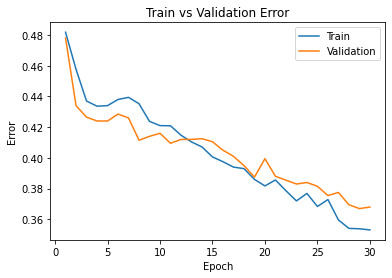

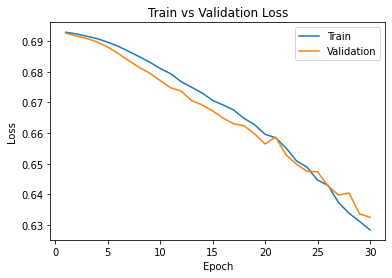

In [ ]:
large_net = LargeNet()
train_net(large_net, 512, 0.01, 30)
model_path = get_model_name("large", batch_size=512, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

Now, by increasing the batch size to 512, the model takes significantly less time to train, it being approximately 20% more efficient. The training and validation curves for both error and less are very similar and they trend consistently negative and appear to be quite smooth.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.432625, Train loss: 0.6775410465598106 |Validation err: 0.3785, Validation loss: 0.651269543170929
Epoch 2: Train err: 0.367875, Train loss: 0.6389183864593506 |Validation err: 0.3495, Validation loss: 0.6170854353904724
Epoch 3: Train err: 0.340375, Train loss: 0.6114947981238366 |Validation err: 0.343, Validation loss: 0.6361264021396636
Epoch 4: Train err: 0.31175, Train loss: 0.5834803532958031 |Validation err: 0.3415, Validation loss: 0.6126863491535187
Epoch 5: Train err: 0.301125, Train loss: 0.5638278910517692 |Validation err: 0.311, Validation loss: 0.5762235834598541
Epoch 6: Train err: 0.28475, Train loss: 0.5464649626612663 |Validation err: 0.3045, Validation loss: 0.5770110754966736
Epoch 7: Train err: 0.270625, Train loss: 0.5266695675551891 |Validation err: 0.2965, Validation loss: 0.5703191385269165
Epoch 8: Train err: 0.254, Train loss: 0.5092709631323814 |Validation err: 

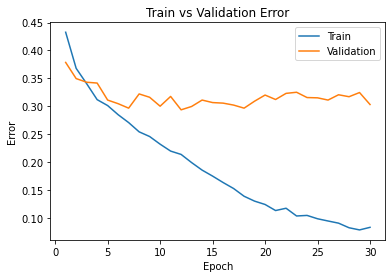

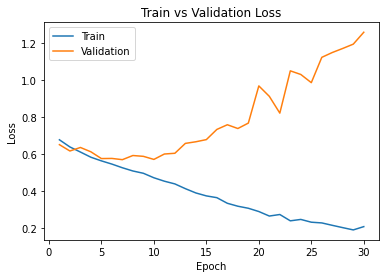

In [ ]:
large_net = LargeNet()
train_net(large_net, 16, 0.01, 30)
model_path = get_model_name("large", batch_size=16, learning_rate=0.01, epoch=29)
plot_training_curve(model_path)

With a batch size of 16 this time, the validation curves diverged from the training curves by the time the epoch was about 5. This is not necessarily a good sign as it could signal that the model was overfitting as the training error continues to decrease while the validation error is about 3 times as large at 30 epochs.



## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

Based on the plots above, I would choose a moderate batch size of 128 with a lower learning rate of 0.005. Lowering the batch size earlier didn't really help and setting it extremely high wasn't amazing either, so I'd like to try a moderate level. Additionally, a lower learning rate would move things in a smaller step which could improve a accuracy

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.466625, Train loss: 0.6925613265188914 |Validation err: 0.4305, Validation loss: 0.6916250437498093
Epoch 2: Train err: 0.45025, Train loss: 0.6910346150398254 |Validation err: 0.4295, Validation loss: 0.6889703683555126
Epoch 3: Train err: 0.4305, Train loss: 0.6885887715551589 |Validation err: 0.4165, Validation loss: 0.6849999390542507
Epoch 4: Train err: 0.430625, Train loss: 0.6850015464283171 |Validation err: 0.4125, Validation loss: 0.679713387042284
Epoch 5: Train err: 0.420875, Train loss: 0.6813878568391951 |Validation err: 0.41, Validation loss: 0.676276832818985
Epoch 6: Train err: 0.415625, Train loss: 0.6772933602333069 |Validation err: 0.413, Validation loss: 0.6729828007519245
Epoch 7: Train err: 0.405125, Train loss: 0.6732233772202144 |Validation err: 0.406, Validation loss: 0.6695911288261414
Epoch 8: Train err: 0.4005, Train loss: 0.6694089571634928 |Validation err: 0.4

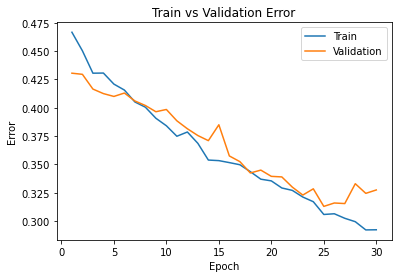

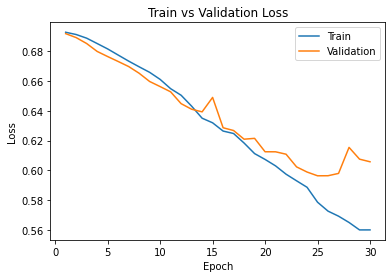

In [ ]:
large_net = LargeNet()

train_net(large_net, batch_size=128,learning_rate=0.005, num_epochs=30)
model_path = get_model_name("large", batch_size=128, learning_rate=0.005, epoch=29)
plot_training_curve(model_path)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

Based on the results above, this time I'd like to try lowering the learning rate a little bit more to see if there is any more improvement. This time I will try 0.0001. The validation curve looks good until about the 25 epoch mark where it slightly diverges and plateaus. 



### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.488375, Train loss: 0.6930624028993031 |Validation err: 0.4965, Validation loss: 0.6931615360081196
Epoch 2: Train err: 0.48625, Train loss: 0.6930225396913196 |Validation err: 0.497, Validation loss: 0.6931003779172897
Epoch 3: Train err: 0.484875, Train loss: 0.6930104787387545 |Validation err: 0.497, Validation loss: 0.6930902600288391
Epoch 4: Train err: 0.48375, Train loss: 0.6929737159184047 |Validation err: 0.4975, Validation loss: 0.6930629424750805
Epoch 5: Train err: 0.481625, Train loss: 0.6929437924945165 |Validation err: 0.4925, Validation loss: 0.6929637640714645
Epoch 6: Train err: 0.480375, Train loss: 0.6929201266122242 |Validation err: 0.4925, Validation loss: 0.6929542943835258
Epoch 7: Train err: 0.4775, Train loss: 0.6928898332610963 |Validation err: 0.492, Validation loss: 0.6929386593401432
Epoch 8: Train err: 0.47625, Train loss: 0.6928518338808938 |Validation err: 

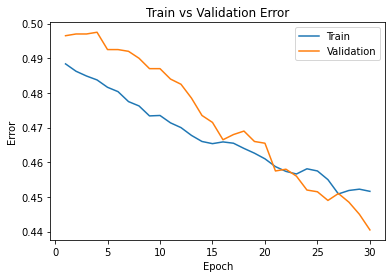

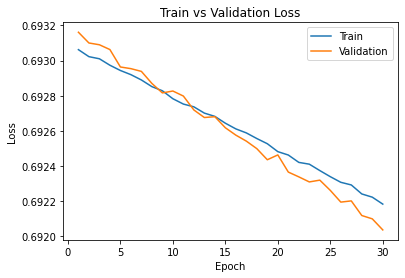

In [ ]:
large_net = LargeNet()

train_net(large_net,batch_size=128,learning_rate=0.0001,num_epochs=30)
model_path = get_model_name("large", batch_size=128, learning_rate=0.0001, epoch=29)
plot_training_curve(model_path)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

In [ ]:
net = LargeNet()
model_path = get_model_name("large", batch_size=128, learning_rate=0.005, epoch=29)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

The large net seemed to perform just slightly better in terms of validation errors, although both nets were pretty similar. Aside from this, the test with the moderate batch size of 128 and learning rate of 0.005 produced good results so these were the parameters I chose.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=128)

testing = nn.BCEWithLogitsLoss()

test_err, test_loss = evaluate(net, test_loader, testing)
print(test_err, test_loss)

val_err, val_loss = evaluate(net, val_loader, testing)
print(val_err, val_loss)

Files already downloaded and verified
Files already downloaded and verified
0.312 0.5874807238578796
0.3275 0.6071126200258732


The test classification error for the model is 0.312


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

The test error is slightly less than the validation error which contradicts our expectations of a higher validation error. We fit the hyperparameters to the training data so technically the validation error would be less since the model has been trained to take on this data which hasn't been seen before. 

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

When a model is being trained it is very important that the test data is only used when you are actually ready to test the model. You want to feed your model fresh unseen data to see how it really performs in an unbiased way. You don't want to risk over/under fitting with the testing data because then you are just fitting the model to work with this data. 

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
# Below is the ANN from Lab 1

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

torch.manual_seed(1) # set the random seed

# define a 2-layer artificial neural network
class Pigeon(nn.Module):
    def __init__(self):
        super(Pigeon, self).__init__()
        self.layer1 = nn.Linear(3*32*32, 60) 
        self.layer2 = nn.Linear(60,30)
        self.layer3 = nn.Linear(30,1)
        self.name = "pigeon"

    def forward(self, img):
        flattened = img.view(-1,3 * 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)  
        activation2 = F.relu(activation2)
        activation3 = self.layer3(activation2)
        return activation3.squeeze(1)

pigeon = Pigeon()

train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=128)

train_net(pigeon,batch_size=128,learning_rate=0.005,num_epochs=30)

testing = nn.BCEWithLogitsLoss()

test_err, test_loss = evaluate(net, test_loader, testing)
print(test_err)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.462875, Train loss: 0.6887138135849483 |Validation err: 0.413, Validation loss: 0.6817390583455563
Epoch 2: Train err: 0.402875, Train loss: 0.673291233796922 |Validation err: 0.4135, Validation loss: 0.6662253439426422
Epoch 3: Train err: 0.398, Train loss: 0.6613584927150181 |Validation err: 0.411, Validation loss: 0.6599488668143749
Epoch 4: Train err: 0.3915, Train loss: 0.6526707410812378 |Validation err: 0.395, Validation loss: 0.6556544378399849
Epoch 5: Train err: 0.378625, Train loss: 0.6455453132826184 |Validation err: 0.3875, Validation loss: 0.6504261307418346
Epoch 6: Train err: 0.366375, Train loss: 0.6378785324475121 |Validation err: 0.392, Validation loss: 0.6492001637816429
Epoch 7: Train err: 0.357125, Train loss: 0.6304712390142774 |Validation err: 0.383, Validation loss: 0.6463685818016529
Epoch

Overall, we see that the CNN is better than the ANN in classifying dogs and cats. The errors are very similar but the CNN has more layers therefore the accuracy is much better. We should always choose a CNN over an ANN for image classification.